## Saving a Cats Meow v Dogs Bork Model

This is a minimal example showing how to train a fastai model on Kaggle, and save it so you can use it in your app.

In [1]:
# Make sure we've got the latest version of fastai:
!pip install -Uqq fastai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.3 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.3 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.3 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.3 requires wrapt~=1.12.1, but you have wrapt 1.14.0 which is incompatible.
tensorflow-transform 1.7.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow-transform 1.7.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.3 which is incompatible.
tensorflow-serving-api 2.8.0 requires tensorflow<3,>=2.8.0, but you have tensorflow 2.6.3 which i

In [2]:
from fastai.vision.all import *
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd
import shutil

Download ESC-50 dataset and set up the directories

In [3]:
# Remove old zips
!rm -rf /kaggle/working/*.zip*

# Download ESC-50 dataset
!wget -q https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip -q -o master.zip

# Load metadata
meta_df = pd.read_csv('ESC-50-master/meta/esc50.csv')

# Create directories
cat_folder = Path('animal_sounds/cat')
dog_folder = Path('animal_sounds/dog')
cat_folder.mkdir(parents=True, exist_ok=True)
dog_folder.mkdir(parents=True, exist_ok=True)

# Extract cat and dog files
cat_files = meta_df[meta_df['category'] == 'cat']
dog_files = meta_df[meta_df['category'] == 'dog']

# Copy files to respective folders
for _, row in cat_files.iterrows():
    src = f"ESC-50-master/audio/{row['filename']}"
    dst = f"animal_sounds/cat/{row['filename']}"
    shutil.copy(src, dst)
    
for _, row in dog_files.iterrows():
    src = f"ESC-50-master/audio/{row['filename']}"
    dst = f"animal_sounds/dog/{row['filename']}"
    shutil.copy(src, dst)

print(f"Copied {len(cat_files)} cat sounds and {len(dog_files)} dog sounds")

# Now use 'animal_sounds' as your audio_folder
audio_folder = 'animal_sounds'

Copied 40 cat sounds and 40 dog sounds


Create a helper function to generate spectrograms:

In [4]:
def create_spectrogram(audio_path, save_path=None):
    y, sr = librosa.load(audio_path)
    # create mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128
    )
    # convert to log scale (dB)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # plot and save as image
    plt.figure(figsize=(8,6))
    librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel')
    plt.tight_layout()
    plt.axis('off')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        return save_path
    else:
        plt.close()
        return log_mel_spec

In [5]:
# Set up folders
spec_folder = './spectrograms'
Path(spec_folder).mkdir(exist_ok=True, parents=True)

# Process audio files to spectrograms
for label in ['cat', 'dog']:
    (Path(spec_folder)/label).mkdir(exist_ok=True)

    audio_path = Path(f"{audio_folder}/{label}")
    if audio_path.exists():
        files = list(audio_path.glob("*.wav"))
        print(f"Prcoessing {len(files)} {label} audio files...")

        for i, file in enumerate(files):
            output_file = Path(spec_folder)/label/f"{file.stem}.png"
            create_spectrogram(str(file), str(output_file))
            if i % 10 == 0:
                print(f"Processed {i}/{len(files)} files")

print(f"Total spectrograms created: {len(list(Path(spec_folder).glob('**/*.png')))}")

Prcoessing 40 cat audio files...
Processed 0/40 files
Processed 10/40 files
Processed 20/40 files
Processed 30/40 files
Prcoessing 40 dog audio files...
Processed 0/40 files
Processed 10/40 files
Processed 20/40 files
Processed 30/40 files
Total spectrograms created: 80


In [6]:
sample_cat = list(Path(f"{spec_folder}/cat").glob("*.png"))[0]
sample_dog = list(Path(f"{spec_folder}/dog").glob("*.png"))[0]

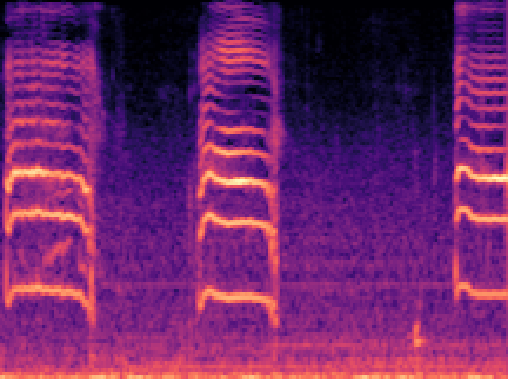

In [7]:
Image.open(sample_cat)

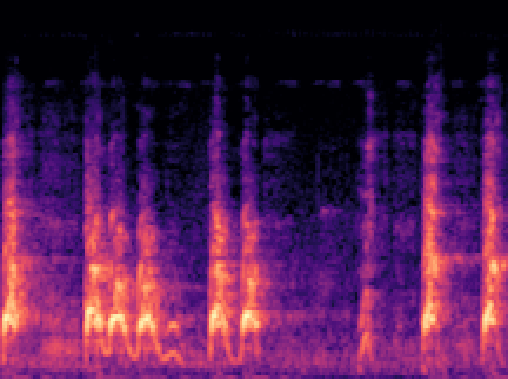

In [8]:
Image.open(sample_dog)

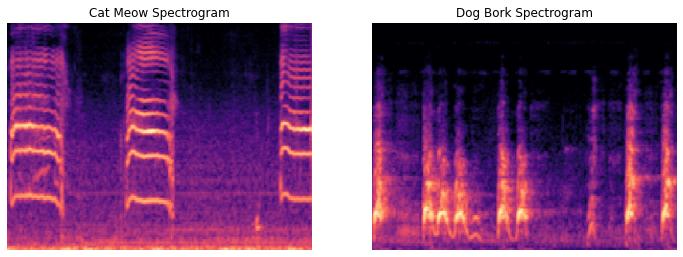

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(sample_cat))
plt.title("Cat Meow Spectrogram")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(plt.imread(sample_dog))
plt.title("Dog Bork Spectrogram")
plt.axis('off')
plt.show()

We need a way to label our images as dog borks or cat mewos. In this dataset, pictures of cat meow spectrograms are given a filename that starts with a capital letter:

Now we can create our `DataLoaders`:

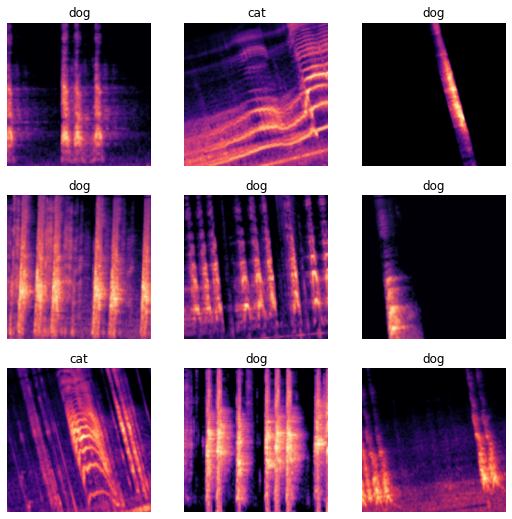

In [10]:
# Create DataBlock and train model
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(do_flip=True, max_rotate=15, max_zoom=1.1, max_warp=0)]
)

dls = dblock.dataloaders(spec_folder, bs=16)
dls.show_batch()

... and train our model, a resnet50:

In [11]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.796828,0.522984,0.312500,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.594697,0.038958,0.000000,00:01
1,0.479440,0.064959,0.062500,00:01
2,0.535871,0.088171,0.062500,00:01
3,0.435531,0.048109,0.000000,00:01


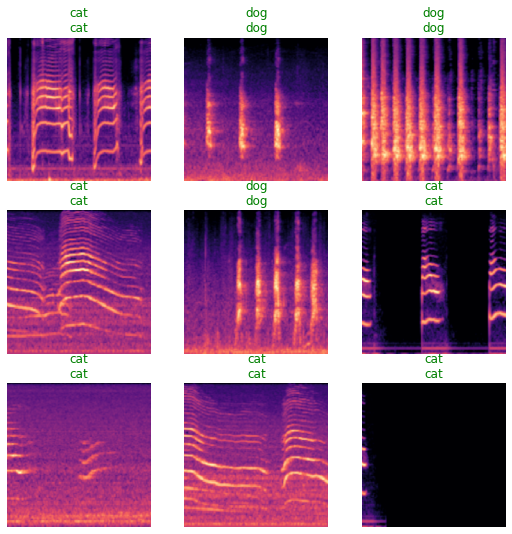

In [12]:
learn.show_results()

Now we can export our trained `Learner`. This contains all the information needed to run the model:

In [13]:
learn.export('model.pkl')

Finally, open the Kaggle sidebar on the right if it's not already, and find the section marked "Output". Open the `/kaggle/working` folder, and you'll see `model.pkl`. Click on it, then click on the menu on the right that appears, and choose "Download". After a few seconds, your model will be downloaded to your computer, where you can then create your app that uses the model.